<a href="https://colab.research.google.com/github/sdabney5/hudlink/blob/main/hudlink_notebook.ipynb?copy=true" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **hudlink** - Automated ACS-HUD data linking for housing analysis  

---
---
### Welcome to hudlink's interactive notebook!

**Click "Run all" before proceeding.**



---


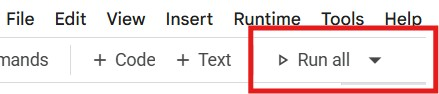



---



### 1 ▸  Get a (free) IPUMS API token  
1. Create an IPUMS USA account - <https://usa.ipums.org/usa/>  
2. Copy your API token from “Account - API Keys”.  
3. After you click *Run hudlink*, paste the token when prompted.

### 2 ▸  Choose states, years, and HUD programs  
Use the check-boxes to pick any combination you need.


*   *Note, depending on IPUMS server speed and the size of the state, this could take 5-10 minutes per state / year combination.*

### 3 ▸  Click **Run hudlink**  
hudlink will:  
* download the ACS PUMS files,
* crosswalk geo data to fill ay mising county data
* apply correct county and household size HUD income limits,  
* link HUD's Picture of Subsidized Housing data,  
* and export two CSVs per state:  

| File | What’s inside |
|------|---------------|
| **`*_eligibility_*.csv`** | Household/family-level records, all selected ACS vars, eligibility flags (`Eligible_30`, `Eligible_50`, `Eligible_80`), protected-class indicators, survey weights. |
| **`*_summary_*.csv`** | County-level totals, HUD program counts, allocation rates, voucher gaps. |


> **Want full flexibility?**  
> pip-install `hudlink` locally (or clone the repo) to pass any IPUMS variable list, change income-limit aggregation, and more.


<details>
<summary><b>Advanced configuration options (click to expand)</b></summary>

### Advanced configuration options

### Family vs. Household (`split_households_into_families`)
*Off by default.*  
When `True`, hudlink treats each family unit in a multi-family household separately. HUD-program eligibility will be considered separaretly for each family. This may be useful in areas with many multi-generational households.

### Group-quarters exclusion (`exclude_group_quarters`)
*Default: `True`*  
Households in institutional group quarters (prisons, dorms, nursing homes) remain in the data but are not flagged as eligible, regardless of income.




# 1. IPUMS Token





In [ ]:
# @title 1 · Enter IPUMS API token {display-mode:"form"}
from IPython.display import display, HTML

display(HTML("<h3>IPUMS API token</h3>"))
display(token_ui)          # ← token_ui is built in the hidden Setup cell

# 2. Options

In [ ]:
# @title Select hudlink Options {display-mode:"code"}
from google.colab import output
output.enable_custom_widget_manager()

from IPython.display import display, HTML

display(HTML("<h3>Select states</h3>"));            display(state_grid)
display(HTML("<h3>Select ACS years</h3>"));         display(year_grid)
display(HTML("<h3>Select HUD programs</h3>"));      display(program_grid)
display(HTML("<h3>Advanced Options</h3>"));
display(widgets.VBox([exclude_gq_cb, split_fam_cb]))


# 3. Run hudlink

In [ ]:
display(run_button)

In [ ]:
# Run to View Allocation Map
from IPython.display import HTML, display
import pathlib, google.colab.output as colab_out

map_path = pathlib.Path("/content/hudlink_output/hud_allocation_gap_map_2023.html")

if map_path.exists():
    url = colab_out.serve_file(map_path)          # stream the file
    display(HTML(f'<h4>HUD allocation-gap map (2023)</h4>'
                 f'<iframe src="{url}" width="100%" height="600"></iframe>'))
else:
    display(HTML("<b style='color:red'>No allocation-gap map found. "
                 "Run hudlink with <code>--create-gap-visual</code> first.</b>"))


hudlink notebook under the hood:

In [ ]:
# @title install, widgets, etc {display-mode:"code"}
%%capture
# ── Install Colab-native widget stack + hudlink every session ──────────────
!pip install -q "ipywidgets<8" "hudlink==3.1.0" tqdm

# ----------------------- Python setup starts here -------------------------
import ipywidgets as widgets, pathlib, zipfile, time, subprocess, shlex, textwrap, os
from IPython.display import HTML, display, clear_output
from google.colab import files

# ── Widget builders ───────────────────────────────────────────────────────
def build_state_grid():
    codes = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA',
             'HI','IA','ID','IL','IN','KS','KY','LA','MA','MD',
             'ME','MI','MN','MO','MS','MT','NC','ND','NE','NH',
             'NJ','NM','NV','NY','OH','OK','OR','PA','RI','SC',
             'SD','TN','TX','UT','VA','VT','WA','WI','WV','WY','DC']
    checks = {c: widgets.Checkbox(description=c, indent=False,
                                  value=(c=='FL'),
                                  layout=widgets.Layout(width='45px'))
              for c in codes}
    rows = [widgets.HBox([checks[c] for c in codes[i:i+10]]) for i in (0,10,20,30)]
    rows.append(widgets.HBox([checks[c] for c in codes[40:]]))
    return widgets.VBox(rows), checks

def build_year_grid():
    years = list(range(2006, 2024))
    checks = [widgets.Checkbox(description=str(y), indent=False,
                               value=(y==2023),
                               layout=widgets.Layout(width='55px'))
              for y in years]
    grid = widgets.GridBox(
        checks,
        layout=widgets.Layout(grid_template_columns="repeat(4,55px)", grid_gap="2px 6px"))
    return grid, checks

def build_program_panel():
    labels = ["Summary of All HUD Programs","Mod Rehab","Public Housing",
              "Section 236","Section 8 NC/SR","LIHTC","Housing Choice Vouchers",
              "Multi-Family Other","811/PRAC","202/PRAC"]
    checks = [widgets.Checkbox(description=lab, indent=False,
                               value=(lab=="Summary of All HUD Programs"),
                               layout=widgets.Layout(width='350px'))
              for lab in labels]
    grid = widgets.GridBox(
        checks,
        layout=widgets.Layout(grid_template_columns="repeat(2,200px)", grid_gap="2px 6px"))
    return grid, checks

# ── IPUMS token widget & callback ─────────────────────────────────────────
token_box = widgets.Password(
    placeholder="Paste IPUMS API token",
    layout=widgets.Layout(width="50%"))
save_btn  = widgets.Button(description="Save", button_style="success")

def save_token(_):
    tok = token_box.value.strip()
    if not tok:
        return
    # Hudlink default file
    secret_path = pathlib.Path("secrets/ipums_token.txt")
    secret_path.parent.mkdir(parents=True, exist_ok=True)
    secret_path.write_text(tok)
    # Convenience copy
    home_path = pathlib.Path("~/.ipums_token").expanduser()
    home_path.write_text(tok)
    # Env-var fallback
    os.environ["IPUMS_API_KEY"] = tok
    token_box.value, token_box.disabled, save_btn.disabled = "", True, True
    display(HTML(f"<b>✅ Token saved to {secret_path}</b>"))

save_btn.on_click(save_token)
token_ui = widgets.HBox([token_box, save_btn])

# ── Instantiate widgets once ──────────────────────────────────────────────
state_grid,  _state_checks   = build_state_grid()
year_grid,   _year_checks    = build_year_grid()
program_grid,_program_checks = build_program_panel()
exclude_gq_cb = widgets.Checkbox(value=True,
                                 description="Exclude group-quarter households",
                                 indent=False)
split_fam_cb  = widgets.Checkbox(value=False,
                                 description="Split households into families",
                                 indent=False)
run_button = widgets.Button(description='Run hudlink', button_style='primary')

# Helper lambdas
get_states   = lambda: [cb.description for cb in _state_checks.values() if cb.value]
get_years    = lambda: [int(cb.description) for cb in _year_checks if cb.value]
get_programs = lambda: [cb.description for cb in _program_checks if cb.value]

# ── Main click-handler -----------------------------------------------------
def run_pipeline(_):
    # guard: token present?
    if not pathlib.Path("secrets/ipums_token.txt").exists():
        display(HTML("<b style='color:red'>Save your IPUMS token first.</b>"))
        return

    # build CLI string
    cmd = "hudlink " + \
          "-s " + " ".join(get_states()) + " " + \
          "-y " + " ".join(map(str, get_years())) + " " + \
          "--programs \"" + ",".join(get_programs()) + "\" " + \
          ("--split-families " if split_fam_cb.value else "") + \
          ("--exclude-group-quarters " if exclude_gq_cb.value else "") + \
          "--output-dir /content/hudlink_output"

    print("▶", cmd)
    get_ipython().system(cmd)

run_button.on_click(run_pipeline)
